In [ ]:
!pip install --upgrade yfinance>=0.1.70
!pip install --upgrade pandas>=1.3
!pip install tqdm
!pip install arch

You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
import scipy.stats as ss
import matplotlib.pyplot as plt
import arch

In [ ]:
quotes = yf.download("AAPL", "2016-01-01", "2020-12-31")
prices = quotes['Adj Close']
returns = prices.pct_change().dropna().rename('Returns')
returns

[*********************100%***********************]  1 of 1 completed


Date
2016-01-05   -0.025059
2016-01-06   -0.019570
2016-01-07   -0.042204
2016-01-08    0.005288
2016-01-11    0.016192
                ...   
2020-12-23   -0.006976
2020-12-24    0.007712
2020-12-28    0.035766
2020-12-29   -0.013315
2020-12-30   -0.008527
Name: Returns, Length: 1257, dtype: float64

We need stationary data for our analysis. Let's see what's stationary...

<AxesSubplot:xlabel='Date'>

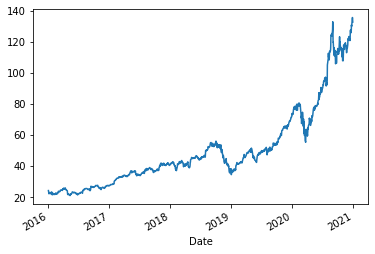

In [ ]:
prices.plot()

Maybe take first differences...

<AxesSubplot:xlabel='Date'>

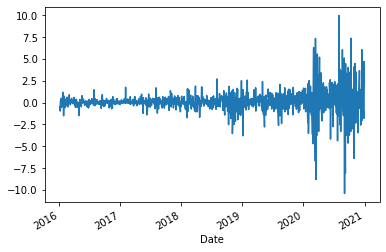

In [ ]:
prices.diff().plot()

Returns look more stationary...

<AxesSubplot:xlabel='Date'>

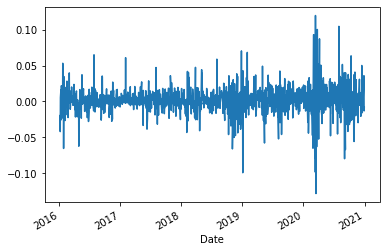

In [ ]:
prices.pct_change().plot()

In [ ]:
alpha = 0.99

In [ ]:
def calculate_VaR_HS(returns, alpha):
    return -np.percentile(returns.values, (1 - alpha) * 100, method="inverted_cdf")


In [ ]:
calculate_VaR_HS(returns, alpha)

0.056018111245177526

The `quantile` method does interpolation by default. It might be a sensible thing to do, but it's not what we want here.

In [ ]:
PnL = pd.Series(range(-10, 0))
print(PnL)
print(calculate_VaR_HS(PnL, 0.89), calculate_VaR_HS(PnL, 0.90), calculate_VaR_HS(PnL, 0.91))

0   -10
1    -9
2    -8
3    -7
4    -6
5    -5
6    -4
7    -3
8    -2
9    -1
dtype: int64
9 10 10


In [ ]:
print(pd.Series([1,2,3,4,5,6,7,8,9,10]).quantile(0.9))
print(pd.Series([1,2,3,4,5,6,7,8,9,10]).quantile(0.9, interpolation='lower'))
print(np.percentile([1,2,3,4,5,6,7,8,9,10], 90, method='inverted_cdf'))
print(pd.Series([1,2,3,4,5,6,7,8,9,10]).quantile(0.95))
print(pd.Series([1,2,3,4,5,6,7,8,9,10]).quantile(0.95, interpolation='lower'))
print(np.percentile([1,2,3,4,5,6,7,8,9,10], 95, method='inverted_cdf'))

9.1
9
9
9.549999999999999
9
10


Apply it to the rolling window

In [ ]:
import typing

def calc_VaR(returns : pd.Series,
             VaR_fun, #: typing.Callable[pd.Series, *args, **kwargs] -> float,
             window_length: int,
             *args, progress=None, **kwargs):
    result = [np.nan] * window_length
    window = range(len(returns) - window_length)
    if progress is not None:
        window = progress(window)
        
    for i in window:
        result.append(VaR_fun(returns[i: i + window_length], *args, **kwargs))

    return pd.Series(result, index=returns.index, name=VaR_fun.__name__)

In [ ]:
a = pd.Series([0,1,2,3,4,5,6,5,4,3,2,1,0])
t1 = calc_VaR(a, max, 4)
t2 = calc_VaR(a, calculate_VaR_HS, 4, alpha=0.75)
print(pd.DataFrame({'Data': a, 'Rolling Max': t1, 'Rolling Min': t2}))

    Data  Rolling Max  Rolling Min
0      0          NaN          NaN
1      1          NaN          NaN
2      2          NaN          NaN
3      3          NaN          NaN
4      4          3.0          0.0
5      5          4.0         -1.0
6      6          5.0         -2.0
7      5          6.0         -3.0
8      4          6.0         -4.0
9      3          6.0         -4.0
10     2          6.0         -3.0
11     1          5.0         -2.0
12     0          4.0         -1.0


In [ ]:
VaR_HS = calc_VaR(returns, calculate_VaR_HS, 252, alpha)
VaR_HS

Date
2016-01-05         NaN
2016-01-06         NaN
2016-01-07         NaN
2016-01-08         NaN
2016-01-11         NaN
                ...   
2020-12-23    0.080061
2020-12-24    0.080061
2020-12-28    0.080061
2020-12-29    0.080061
2020-12-30    0.080061
Name: calculate_VaR_HS, Length: 1257, dtype: float64

Actually, Pandas has a built-in function for it.
Warning! It works incorrectly for `pandas < 1.2`.

In [ ]:
def calc_VaR_2(returns, VaR_fun, window_length, *args, **kwargs):
    return returns.rolling(window=window_length, closed='left').apply(
        VaR_fun, args=args, kwargs=kwargs,
    )


VaR_HS_2 = calc_VaR_2(returns, calculate_VaR_HS, 252, alpha)
(VaR_HS - VaR_HS_2).abs().max()

0.0

In [ ]:
import pandas as pd
pd.Series(range(10)).rolling(window=4, closed='left').apply(max)

0    NaN
1    NaN
2    NaN
3    NaN
4    3.0
5    4.0
6    5.0
7    6.0
8    7.0
9    8.0
dtype: float64

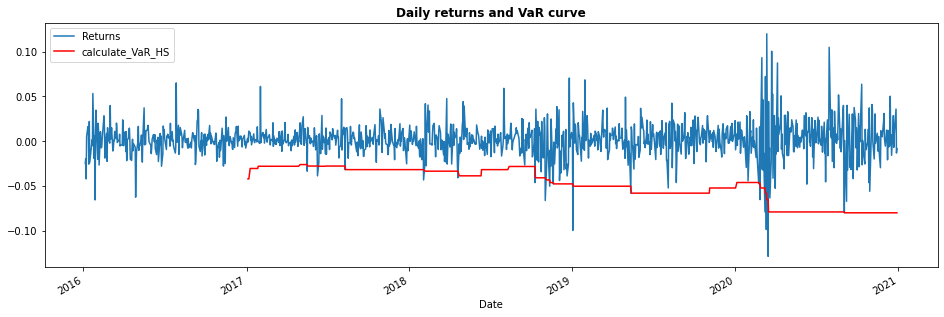

In [ ]:
fig = plt.figure(figsize=(16, 5))

returns.plot()
(-VaR_HS).plot(color="r")

plt.title("Daily returns and VaR curve", weight="bold")
plt.legend()
plt.show()

In [ ]:
# use scipy.stats.norm
def calculate_VaR_normal(returns, alpha):
    raise NotImplementedError()
    mu, std = scipy.stats.norm.fit(returns) 


VaR_norm = calc_VaR(returns, calculate_VaR_normal, 252, alpha)
VaR_norm

Date
2016-01-04         NaN
2016-01-05         NaN
2016-01-06         NaN
2016-01-07         NaN
2016-01-08         NaN
                ...   
2020-12-23    0.065223
2020-12-24    0.065269
2020-12-28    0.065276
2020-12-29    0.065301
2020-12-30    0.065417
Name: calculate_VaR_normal, Length: 1258, dtype: float64

In [ ]:
# use scipy.stats.norm
def calculate_VaR_normal(returns, alpha):
    mu, std = ss.norm.fit(returns)
    return - ss.norm.ppf(1 - alpha, mu, std)


VaR_norm = calc_VaR(returns, calculate_VaR_normal, 252, alpha)
VaR_norm

Date
2016-01-05         NaN
2016-01-06         NaN
2016-01-07         NaN
2016-01-08         NaN
2016-01-11         NaN
                ...   
2020-12-23    0.065223
2020-12-24    0.065269
2020-12-28    0.065276
2020-12-29    0.065301
2020-12-30    0.065417
Name: calculate_VaR_normal, Length: 1257, dtype: float64

In [ ]:
import tqdm
def calculate_VaR_parametric(returns, alpha, family=ss.norm):
    params = family.fit(returns)
    return -family.ppf(1 - alpha, *params)


VaR_t = calc_VaR(returns, calculate_VaR_parametric, 252, alpha, family=ss.t, progress=tqdm.tqdm)
VaR_t

100%|██████████| 1005/1005 [00:50<00:00, 19.90it/s]


Date
2016-01-05         NaN
2016-01-06         NaN
2016-01-07         NaN
2016-01-08         NaN
2016-01-11         NaN
                ...   
2020-12-23    0.082289
2020-12-24    0.082174
2020-12-28    0.082535
2020-12-29    0.082077
2020-12-30    0.081875
Name: calculate_VaR_parametric, Length: 1257, dtype: float64

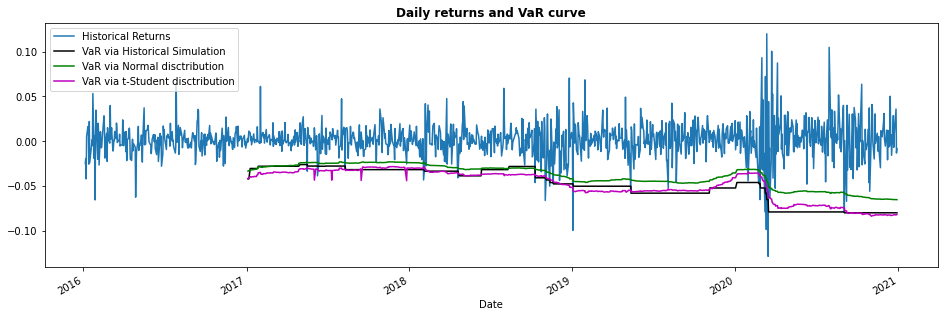

In [ ]:
fig = plt.figure(figsize=(16, 5))
returns.plot()
(-VaR_HS).plot(color="k")
(-VaR_norm).plot(color="g")
(-VaR_t).plot(color="m")
plt.title("Daily returns and VaR curve", weight="bold")
plt.legend(
    [
        "Historical Returns",
        "VaR via Historical Simulation",
        "VaR via Normal disctribution",
        "VaR via t-Student disctribution",
    ]
)
plt.show()

#### Question: what are those downward spikes in pink?

### Now let's try interest rates

[*********************100%***********************]  1 of 1 completed


<AxesSubplot:xlabel='Date'>

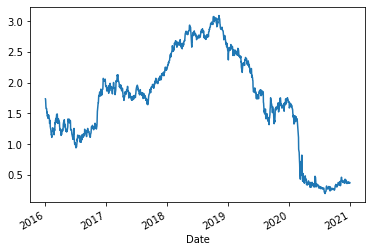

In [ ]:
quotes = yf.download('^FVX', "2016-01-01", "2020-12-31")
rates = quotes['Adj Close']
rates.plot()

<AxesSubplot:xlabel='Date'>

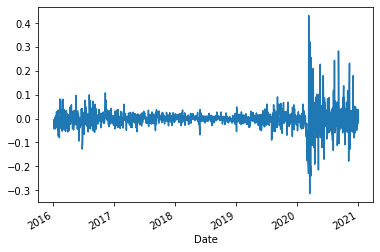

In [ ]:
rates.pct_change().plot()

<AxesSubplot:xlabel='Date'>

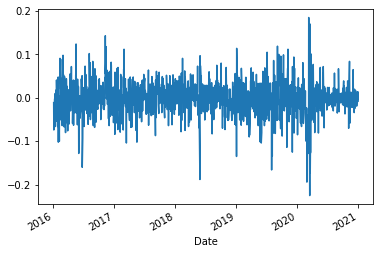

In [ ]:
rates.diff().plot()

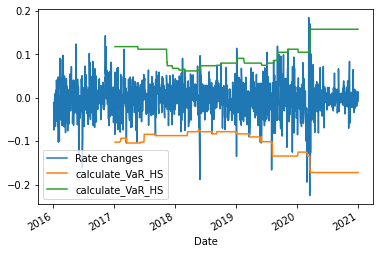

In [ ]:
diffs = rates.diff().dropna().rename('Rate changes')
VaR_lower = calc_VaR(diffs, calculate_VaR_HS, 252, alpha)
VaR_upper = - calc_VaR(diffs, calculate_VaR_HS, 252, 1-alpha)

diffs.plot()
(-VaR_lower).plot()
VaR_upper.plot()
plt.legend()

Now let's tackle the variance clustering with a GARCH model

it works like this:

In [ ]:
mdl = arch.arch_model(returns * 100).fit()
forecast = mdl.forecast(reindex=False)

Iteration:      1,   Func. Count:      6,   Neg. LLF: 224102.08308273923
Iteration:      2,   Func. Count:     14,   Neg. LLF: 2641.633964148714
Iteration:      3,   Func. Count:     20,   Neg. LLF: 2499.404219847384
Iteration:      4,   Func. Count:     26,   Neg. LLF: 2457.387553693071
Iteration:      5,   Func. Count:     32,   Neg. LLF: 680237637.4242471
Iteration:      6,   Func. Count:     38,   Neg. LLF: 2423.574862458706
Iteration:      7,   Func. Count:     44,   Neg. LLF: 2428.275116518733
Iteration:      8,   Func. Count:     50,   Neg. LLF: 2399.1716384812153
Iteration:      9,   Func. Count:     55,   Neg. LLF: 2399.0892964764826
Iteration:     10,   Func. Count:     60,   Neg. LLF: 2399.0859853925876
Iteration:     11,   Func. Count:     65,   Neg. LLF: 2399.085951057933
Iteration:     12,   Func. Count:     69,   Neg. LLF: 2399.0859510582877
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2399.085951057933
            Iterations:

In [ ]:
print(forecast.mean, forecast.variance)

                 h.1
Date                
2020-12-30  0.235726                  h.1
Date                
2020-12-30  3.483356


In [ ]:
# Now we can calculate the quantiles...
μ = forecast.mean.values.item()
σ = np.sqrt(forecast.variance.values.item())
q = ss.norm.ppf(1 - alpha)
VaR = - (μ + σ * q) / 100
print(VaR)

0.04106112097230163


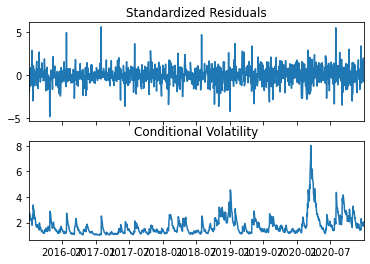

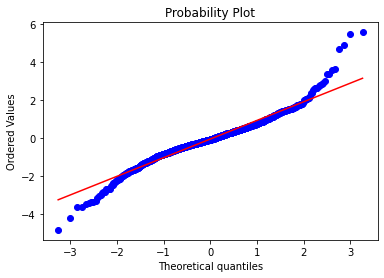

In [ ]:
mdl.plot()
plt.figure()
ss.probplot(mdl.std_resid, plot=plt);

Residuals seem to be not normal...

Iteration:      1,   Func. Count:      7,   Neg. LLF: 33885.31286886207
Iteration:      2,   Func. Count:     16,   Neg. LLF: 19911.609184231667
Iteration:      3,   Func. Count:     24,   Neg. LLF: 3497.895728055013
Iteration:      4,   Func. Count:     31,   Neg. LLF: 3366.505014528151
Iteration:      5,   Func. Count:     38,   Neg. LLF: 6292.569380053035
Iteration:      6,   Func. Count:     45,   Neg. LLF: 2314.033517948861
Iteration:      7,   Func. Count:     51,   Neg. LLF: 3194.9631457617675
Iteration:      8,   Func. Count:     58,   Neg. LLF: 2507.072610559278
Iteration:      9,   Func. Count:     67,   Neg. LLF: 2312.981889511255
Iteration:     10,   Func. Count:     74,   Neg. LLF: 2312.6443279227146
Iteration:     11,   Func. Count:     80,   Neg. LLF: 2312.628496962414
Iteration:     12,   Func. Count:     86,   Neg. LLF: 2312.626068904478
Iteration:     13,   Func. Count:     92,   Neg. LLF: 2312.6259055891105
Iteration:     14,   Func. Count:     98,   Neg. LLF: 2312.6

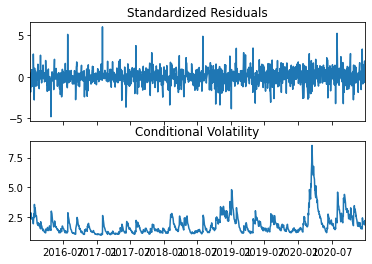

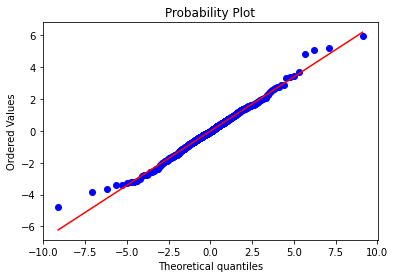

In [ ]:
mdl = arch.arch_model(returns * 100, dist='t')
res = mdl.fit()
forecast = res.forecast(reindex=False)
print(res)
print(forecast.mean, forecast.variance)
res.plot()
plt.figure()
ss.probplot(res.std_resid, dist=ss.t(df=res.params['nu']), plot=plt);

A bit better...

In [ ]:
mdl.distribution

Standardized Student's t distribution, id: 0x7fb3e4d1af10

In [ ]:
# Now we can calculate the quantiles as before, but with a different distribution:
q = mdl.distribution.ppf(1 - alpha, res.params['nu'])
μ = forecast.mean.values.item()
σ = np.sqrt(forecast.variance.values.item())
VaR = - (μ + σ * q)
print(VaR)

5.087473173716608


In [ ]:
print(mdl.distribution.parameter_names())
print(res.params)
**res.params[mdl.distribution.parameter_names()]

['nu']
mu          0.176290
omega       0.132334
alpha[1]    0.165679
beta[1]     0.819258
nu          3.735141
Name: params, dtype: float64


nu    3.735141
Name: params, dtype: float64

In [ ]:
# This is the working version
def calculate_VaR_GARCH(returns, alpha, dist="normal"):
    mdl = arch.arch_model(returns * 100, dist=dist)
    res = mdl.fit(disp="off")
    forecast = res.forecast(reindex=False)
    p = []
    if len(mdl.distribution.parameter_names()) > 0:
        p.append(res.params[mdl.distribution.parameter_names()].values[0])
    q = mdl.distribution.ppf(1 - alpha, p)
    μ = forecast.mean.values.item()
    σ = np.sqrt(forecast.variance.values.item())
    VaR = - (μ + σ * q) / 100
    return VaR
    
calculate_VaR_GARCH(returns, alpha), calculate_VaR_GARCH(returns, alpha, "t")

(0.04106112097230163, 0.05074621447033766)

In [ ]:
VaR_GARCH = calc_VaR(returns, calculate_VaR_GARCH, 252, alpha, progress=tqdm.tqdm, dist="normal")
VaR_GARCH

100%|██████████| 1005/1005 [00:37<00:00, 27.15it/s]


Date
2016-01-05         NaN
2016-01-06         NaN
2016-01-07         NaN
2016-01-08         NaN
2016-01-11         NaN
                ...   
2020-12-23    0.047624
2020-12-24    0.045288
2020-12-28    0.042295
2020-12-29    0.049830
2020-12-30    0.048929
Name: calculate_VaR_GARCH, Length: 1257, dtype: float64

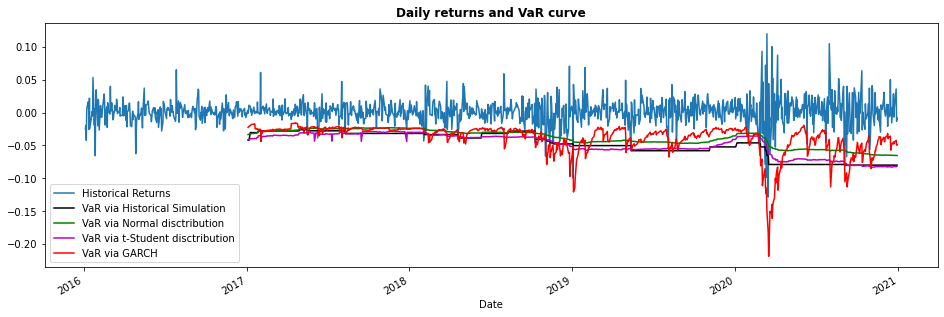

In [ ]:
fig = plt.figure(figsize=(16, 5))
returns.plot()
(-VaR_HS).plot(color="k")
(-VaR_norm).plot(color="g")
(-VaR_t).plot(color="m")
(-VaR_GARCH).plot(color="r")
plt.title("Daily returns and VaR curve", weight="bold")
plt.legend(
    [
        "Historical Returns",
        "VaR via Historical Simulation",
        "VaR via Normal disctribution",
        "VaR via t-Student disctribution",
        "VaR via GARCH",
    ]
)
plt.show()

Filtered Historical Simulation -- take a historical quantile for `q`:

In [ ]:
mdl = arch.arch_model(returns * 100)
res = mdl.fit(disp="off")
forecast = res.forecast(reindex=False)
q = res.std_resid.quantile(1 - alpha)
μ = forecast.mean.values.item()
σ = np.sqrt(forecast.variance.values.item())
VaR = - (μ + σ * q)
print(VaR)

5.139488626937075


In [ ]:
def calculate_VaR_GARCH_FHS(returns, alpha, dist="normal"):
    mdl = arch.arch_model(returns * 100, dist=dist)
    res = mdl.fit(disp="off")
    forecast = res.forecast(reindex=False)
    q = res.std_resid.quantile(1 - alpha)
    μ = forecast.mean.values.item()
    σ = np.sqrt(forecast.variance.values.item())
    VaR = - (μ + σ * q) / 100
    return VaR


calculate_VaR_GARCH_FHS(returns, alpha)

0.05139488626937075

In [ ]:
VaR_GARCH_FHS = calc_VaR(returns, calculate_VaR_GARCH_FHS, 252, alpha, progress=tqdm.tqdm, dist="normal")
VaR_GARCH_FHS

100%|██████████| 1005/1005 [00:35<00:00, 28.27it/s]


Date
2016-01-05         NaN
2016-01-06         NaN
2016-01-07         NaN
2016-01-08         NaN
2016-01-11         NaN
                ...   
2020-12-23    0.052155
2020-12-24    0.049499
2020-12-28    0.046232
2020-12-29    0.054196
2020-12-30    0.053158
Name: calculate_VaR_GARCH_FHS, Length: 1257, dtype: float64

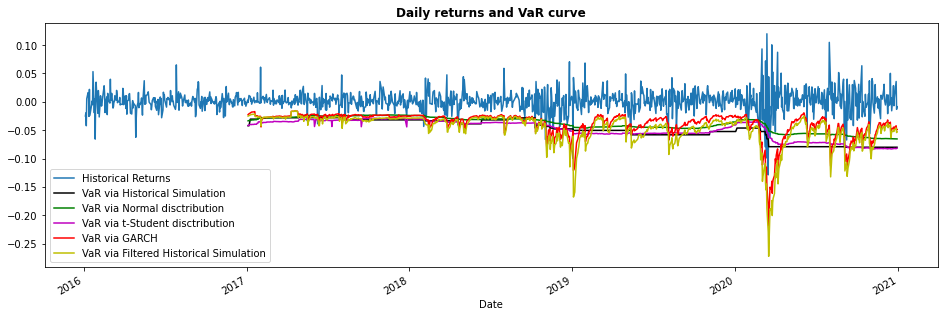

In [ ]:
fig = plt.figure(figsize=(16, 5))
returns.plot()
(-VaR_HS).plot(color="k")
(-VaR_norm).plot(color="g")
(-VaR_t).plot(color="m")
(-VaR_GARCH).plot(color="r")
(-VaR_GARCH_FHS).plot(color='y')
plt.title("Daily returns and VaR curve", weight="bold")
plt.legend(
    [
        "Historical Returns",
        "VaR via Historical Simulation",
        "VaR via Normal disctribution",
        "VaR via t-Student disctribution",
        "VaR via GARCH",
        "VaR via Filtered Historical Simulation"
    ]
)
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=dc69f171-f4bb-4c21-8857-3bf9aef78ad4' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>